In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import shap

In [2]:
pd.options.display.max_columns = None 
pd.options.display.max_rows = None 

In [3]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it, not to be used in a grouping function

    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [4]:
def prepare_data(df):
    x1, x2, x3, x4, x5, x6, target = df['1_week_ago'], df['2_week_ago'], df['3_week_ago'], df['4_week_ago'], df['weeks_since_release'], df['avg_claim_last_month'], df['this_week']
    x1, x2, x3, x4, x5, x6, target = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(target)
    x1, x2, x3, x4, x5, x6, target = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1), target.reshape(-1, 1)
    features = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
    
    return features, target

In [5]:
iphone12_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone12_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone13_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone13_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone14_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/iPhone14_Final.csv', parse_dates=['weeks_monday','month_year'])
iphone_df = pd.read_csv('/data/p_dsi/teams2023/team2/asurion_data/time_series_ML_features_final.csv', parse_dates=['weeks_monday','month_year'])
iphone12 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 12')]
iphone13 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 13')]
iphone14 = iphone_df[(iphone_df['phone_model'] == 'apple iphone 14')]

In [6]:
iphone13_df.drop(['month_year', 'holiday'], axis=1, inplace=True)
iphone14_df.drop(['month_year', 'holiday'], axis=1, inplace=True)

In [9]:
iphone13 = iphone13[(iphone13['weeks_monday'] >= '2021-12-20')] 
iphone13_beg = iphone13.copy().reset_index()
iphone13_beg = iphone13_beg.head(13)
days_since_iphone14_release = iphone13_beg['days_since_release_date'] + 2
iphone13_beg['days_since_release_date'] = days_since_iphone14_release
iphone13_beg['weeks_since_release'] = days_since_iphone14_release // 7 
iphone13_beg['weeks_monday'] = iphone13_beg['weeks_monday'] - pd.Timedelta(days=36)
iphone13_beg['month'] = iphone13_beg['weeks_monday'].dt.month
iphone13_beg['year'] = iphone13_beg['weeks_monday'].dt.year
iphone13_beg['weeks_since_release'] = iphone13_beg['days_since_release_date'].floordiv(7)
iphone13_beg

,index,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
0,76,apple iphone 13,2021-11-14,11,2021,2021-12-01,59,6,8
1,77,apple iphone 13,2021-11-21,11,2021,2021-12-01,66,15,9
2,83,apple iphone 13,2021-11-28,11,2021,2022-01-01,73,7,10
3,85,apple iphone 13,2021-12-05,12,2021,2022-01-01,80,13,11
4,89,apple iphone 13,2021-12-12,12,2021,2022-01-01,87,10,12
5,96,apple iphone 13,2021-12-19,12,2021,2022-01-01,94,11,13
6,99,apple iphone 13,2021-12-26,12,2021,2022-01-01,101,12,14
7,103,apple iphone 13,2022-01-02,1,2022,2022-02-01,108,15,15
8,106,apple iphone 13,2022-01-09,1,2022,2022-02-01,115,23,16
9,109,apple iphone 13,2022-01-16,1,2022,2022-02-01,122,19,17


In [11]:
iphone14 = iphone14.copy()
iphone14['weeks_since_release'] = iphone14['days_since_release_date'].floordiv(7)
iphone14

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim,weeks_since_release
262,apple iphone 14,2022-11-14,11,2022,2022-11-01,59,9,8
267,apple iphone 14,2022-11-21,11,2022,2022-11-01,66,30,9
271,apple iphone 14,2022-11-28,11,2022,2022-11-01,73,23,10
277,apple iphone 14,2022-12-05,12,2022,2022-12-01,80,43,11
283,apple iphone 14,2022-12-12,12,2022,2022-12-01,87,32,12
289,apple iphone 14,2022-12-19,12,2022,2022-12-01,94,36,13
292,apple iphone 14,2022-12-26,12,2022,2022-12-01,101,44,14
299,apple iphone 14,2023-01-02,1,2023,2023-01-01,108,45,15
303,apple iphone 14,2023-01-09,1,2023,2023-01-01,115,59,16
308,apple iphone 14,2023-01-16,1,2023,2023-01-01,122,60,17


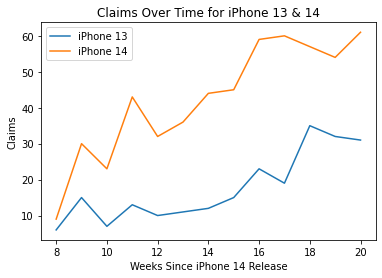

In [12]:
plt.plot(iphone13_beg['weeks_since_release'], iphone13_beg['claim'], label='iPhone 13')
plt.plot(iphone14['weeks_since_release'], iphone14['claim'], label='iPhone 14')

plt.xlabel('Weeks Since iPhone 14 Release')
plt.ylabel('Claims') 
plt.title('Claims Over Time for iPhone 13 & 14')
plt.legend()
plt.show()

In [13]:
iphone14_avg_claim_per_month = iphone14.groupby('month')['claim'].mean().reset_index()
iphone14_avg_claim_per_month

,month,claim
0,1,55.000000
1,2,61.000000
2,11,20.666667
3,12,38.750000


In [14]:
iphone13_avg_claim_per_month = iphone13_beg.groupby('month')['claim'].mean().reset_index()
iphone13_avg_claim_per_month

,month,claim
0,1,24.800000
1,2,31.000000
2,11,9.333333
3,12,11.500000


In [15]:
merged_df = pd.merge(iphone14_avg_claim_per_month, iphone13_avg_claim_per_month, on='month', suffixes=('_14', '_13'))
merged_df['diff'] = merged_df['claim_14'] - merged_df['claim_13']
diff_by_month = merged_df[['month', 'diff']]
diff_by_month

,month,diff
0,1,30.200000
1,2,30.000000
2,11,11.333333
3,12,27.250000


In [21]:
new_iphone13 = iphone13_df.copy()

days_since_iphone14_release = iphone13_df['days_since_release_date'] + 2 
new_iphone13['days_since_release_date'] = days_since_iphone14_release
new_iphone13['weeks_since_release'] = days_since_iphone14_release // 7 
new_iphone13['weeks_monday'] = iphone13_df['weeks_monday'] - pd.Timedelta(days=36)
new_iphone13['month'] = new_iphone13['weeks_monday'].dt.month
new_iphone13['year'] = new_iphone13['weeks_monday'].dt.year
new_iphone13

,days_since_release_date,weeks_monday,month,year,this_week,avg_claim_this_month,avg_claim_last_month,1_week_ago,2_week_ago,3_week_ago,4_week_ago,weeks_since_release
0,52,2021-11-07,11,2021,10,8.25,3.666667,2.0,6.0,3.0,2.0,7
1,59,2021-11-14,11,2021,6,8.25,3.666667,10.0,2.0,6.0,3.0,8
2,66,2021-11-21,11,2021,15,8.25,3.666667,6.0,10.0,2.0,6.0,9
3,73,2021-11-28,11,2021,7,10.60,8.250000,15.0,6.0,10.0,2.0,10
4,80,2021-12-05,12,2021,13,10.60,8.250000,7.0,15.0,6.0,10.0,11
5,87,2021-12-12,12,2021,10,10.60,8.250000,13.0,7.0,15.0,6.0,12
6,94,2021-12-19,12,2021,11,10.60,8.250000,10.0,13.0,7.0,15.0,13
7,101,2021-12-26,12,2021,12,10.60,8.250000,11.0,10.0,13.0,7.0,14
8,108,2022-01-02,1,2022,15,23.00,10.600000,12.0,11.0,10.0,13.0,15
9,115,2022-01-09,1,2022,23,23.00,10.600000,15.0,12.0,11.0,10.0,16


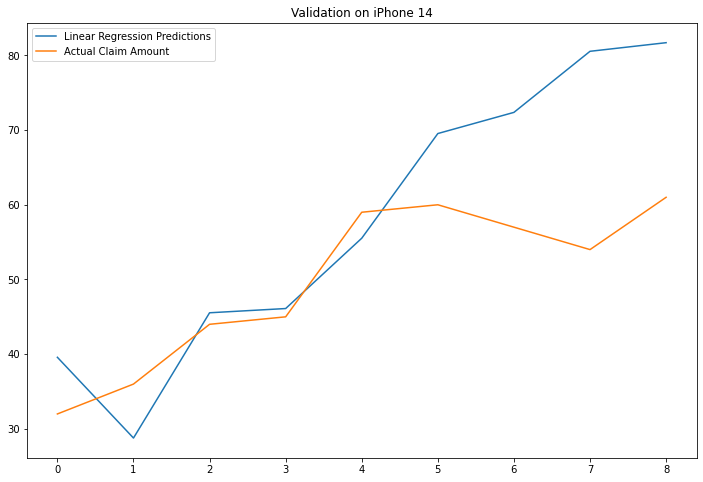

Root Mean sqaured error for Linear Regression model is:  13.271788028252278
WMAPE: 20.78%


In [26]:
iphone13_train = new_iphone13[(new_iphone13['weeks_monday'] <= '2022-08-08')] 
X_train, y_train = prepare_data(iphone13_train)

X_validate, y_validate = prepare_data(iphone14_df)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_validate)
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(lin_pred, label = "Linear Regression Predictions")
plt.plot(y_validate, label = "Actual Claim Amount")
plt.title("Validation on iPhone 14")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(lin_pred, y_validate))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

y_validate_series = pd.Series(y_validate.ravel())
lin_pred_series = pd.Series(lin_pred.ravel())
wmape_score = wmape(y_validate_series, lin_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [27]:
def predict_next_claim_amount(df, weeks_this_month, growth_adjustment):
    for i in range(weeks_this_month): 
        x1 = df.iloc[-1]['this_week']
        x2 = df.iloc[-1]['1_week_ago']
        x3 = df.iloc[-1]['2_week_ago']
        x4 = df.iloc[-1]['3_week_ago']
        days = int(df.iloc[-1]['days_since_release_date']) + 7
        x5 = days // 7 
        x6 = df.iloc[-1]['avg_claim_this_month']

        x1, x2, x3, x4, x5, x6 = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6)
        x1, x2, x3, x4, x5, x6 = x1.reshape(-1, 1), x2.reshape(-1, 1), x3.reshape(-1, 1), x4.reshape(-1, 1), x5.reshape(-1, 1), x6.reshape(-1, 1)
        X_next = np.concatenate((x1, x2, x3, x4, x5, x6), axis = 1)
        next_pred = lin_model.predict(X_next).item()
        next_pred += growth_adjustment

        new_row = {
            'this_week': next_pred,
            '1_week_ago': x1.item(),
            '2_week_ago': x2.item(),
            '3_week_ago': x3.item(),
            '4_week_ago': x4.item(),
            'weeks_since_release': x5.item(),
            'days_since_release_date': days, 
            'avg_claim_last_month': x6.item(),
            'avg_claim_this_month': x6.item()
        }

        df = df.append(new_row, ignore_index=True)

    rolling_avg = df['this_week'].rolling(weeks_this_month).mean().iloc[-1]
    df.iloc[-weeks_this_month:, df.columns.get_loc('avg_claim_this_month')] = rolling_avg
    return df

My Predictions:
[46.10987214 56.12973252 67.97404074 77.18744049 90.07447328]
Actual:
[45 59 60 57 54]


My Prediction Avg claim this month:67.49511183163703
Actual Avg claim this month: 55.0


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


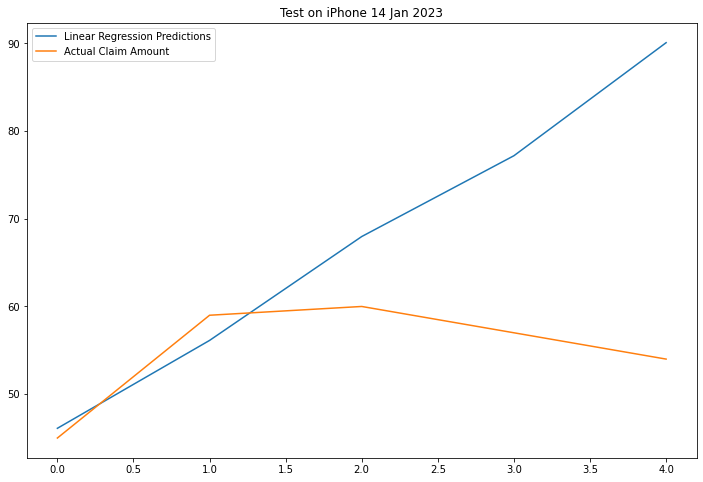

Root Mean sqaured error for Linear Regression model is:  18.87832594735003
WMAPE: 24.81%


In [29]:
weeks_in_Jan23 = 5
iPhone14_predict_Jan23 = iphone14_df.iloc[:3].copy()
iPhone14_predict_Jan23 = predict_next_claim_amount(iPhone14_predict_Jan23, weeks_in_Jan23, 0)

my_pred = iPhone14_predict_Jan23['this_week'].tail(weeks_in_Jan23).to_numpy()
print("My Predictions:")
print(my_pred)

truth = np.array(iphone14_df.iloc[3:8]['this_week'].values)
print("Actual:")
print(truth)

print("\n")

my_pred_avg_claim_this_month = iPhone14_predict_Jan23.iloc[-1]['avg_claim_this_month']
print("My Prediction Avg claim this month:" + str(my_pred_avg_claim_this_month))

actual_avg_claim_this_month = iphone14_df.iloc[3]['avg_claim_this_month']
print("Actual Avg claim this month: " + str(actual_avg_claim_this_month))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(my_pred, label = "Linear Regression Predictions")
plt.plot(truth, label = "Actual Claim Amount")
plt.title("Test on iPhone 14 Jan 2023")
plt.legend(loc="upper left")
plt.show()
rmse_lr = sqrt(mean_squared_error(my_pred, truth))
print("Root Mean sqaured error for Linear Regression model is: ", rmse_lr)

truth_series = pd.Series(truth.ravel())
my_pred_series = pd.Series(my_pred.ravel())
wmape_score = wmape(truth_series, my_pred_series)
print("WMAPE: {:.2%}".format(wmape_score))

In [7]:
iphone13

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim
54,apple iphone 13,2021-11-15,11,2021,2021-11-01,22,2
60,apple iphone 13,2021-11-22,11,2021,2021-11-01,29,3
64,apple iphone 13,2021-11-29,11,2021,2021-11-01,36,6
66,apple iphone 13,2021-12-06,12,2021,2021-12-01,43,2
69,apple iphone 13,2021-12-13,12,2021,2021-12-01,50,10
76,apple iphone 13,2021-12-20,12,2021,2021-12-01,57,6
77,apple iphone 13,2021-12-27,12,2021,2021-12-01,64,15
83,apple iphone 13,2022-01-03,1,2022,2022-01-01,71,7
85,apple iphone 13,2022-01-10,1,2022,2022-01-01,78,13
89,apple iphone 13,2022-01-17,1,2022,2022-01-01,85,10


In [8]:
iphone14

,phone_model,weeks_monday,month,year,month_year,days_since_release_date,claim
262,apple iphone 14,2022-11-14,11,2022,2022-11-01,59,9
267,apple iphone 14,2022-11-21,11,2022,2022-11-01,66,30
271,apple iphone 14,2022-11-28,11,2022,2022-11-01,73,23
277,apple iphone 14,2022-12-05,12,2022,2022-12-01,80,43
283,apple iphone 14,2022-12-12,12,2022,2022-12-01,87,32
289,apple iphone 14,2022-12-19,12,2022,2022-12-01,94,36
292,apple iphone 14,2022-12-26,12,2022,2022-12-01,101,44
299,apple iphone 14,2023-01-02,1,2023,2023-01-01,108,45
303,apple iphone 14,2023-01-09,1,2023,2023-01-01,115,59
308,apple iphone 14,2023-01-16,1,2023,2023-01-01,122,60
